# Problem Set #5

In problem set #5, you are asked to use Cantera to perform kinetic simulations and analysis.
This notebook will be used as a template to pose questions and guide you through the process to reach solutions.

This assignment directly apply material presented in the two Jupyter tutorials presenting in problem sessions 2 and 5.
It is *highly* recommended that, if you haven't already, you watch the recordings and/or work through these tutorials
 before attempting this assignment.

This assignment is intended to expose students to open-source tools and analysis methods for performing kinetic
 simulations, not to test student's programming ability.
While we expect students to first reference the tutorials and documentation available to you, please do not hesitate to
 reach out to your fellow students (as with all problem sets, you are encouraged to work together but must complete and
 submit your own assignments) or your TA's.

*Note:*
Please make sure to refer to the directions at the end of Tutorial #1 regarding saving your work in the
 Jupyter/Binder environment. Please be sure to save your work to your local machine in the **.ipynb** format regularly.
If contacting the TA's by email with questions, please attach your .ipynb file to help them assist you with
 troubleshooting

**Submission:**
When you complete the assignment, please *Print* the notebook (with all output displayed) in **PDF** format for
 submission on Gradescope.
If you choose to complete the assignment in a different form than this notebook (allowed, but *not recommended*), you
 are responsible for determining what deliverables are being asked for in this template and making sure they are
 submitted in an appropriate format.

**Import Statements:**
Do not change anything in the following cell. Packages imported here should be the only required for completing this
 assignment.

In [1]:
import cantera as ct
import numpy as np
import os
import matplotlib.pyplot as plt

**Useful Functions from Problem Session #5/Tutorial #2:**

The following functions that were developed in Tutorial #2 are provided for you here for your reference and use in this
 problem set.
You may modify them should you so choose, or use them as they are.

*Note:* The description of the function contained in triple quotes `"""..."""` directly following the function
 definition `def ....(...):` is called a "docstring".
The docstring describes the function, its parameters, and its return values.
Docstrings are the primary method by which functions are documented in the Python language.
Within Jupyter, you can access this documentation by typing the function name followed by a `?` (see below).

In [2]:
# default parameters passed to functions:
#   You can change these, then re-run this cell to change the defaults used by the functions
T0 = 1200  # K
P0 = 101325  # Pa (1 atm)
phi0 = 1.
fuel0 = {'H2':1.}
oxidizer0 = {'AR':.79, 'O2':.21}  # "airgon"

# user-defined functions to help set up and run simulations

def setup_simulation(sln, T=T0, P=P0, phi=phi0, f=fuel0, ox=oxidizer0):
    """
    Returns a constant-pressure reactor object and reactor network based upon a ct.Solution object and at optionally
     specified starting conditions, or predefined defaults
    :param sln: ct.Solution object specifying mechanism for given simulation
    :param T: float, optional starting temperature (K)
    :param P: float, optional starting pressure (Pa)
    :param phi: float, optional equivalence ratio (-)
    :param f: dict, optional dict specifying fuel composition
    :param ox: dict, optional dict specifying oxidizer composition
    :return tuple: (ct.ConstPressureReactor, ct.ReactorNet)
    """
    sln.set_equivalence_ratio(phi=phi, fuel=f, oxidizer=ox)
    sln.TP = T, P
    r1 = ct.ConstPressureReactor(sln)
    rnet = ct.ReactorNet([r1])
    return r1, rnet


def new_result_dict(sln: ct.Solution, species_list=None):
    """
    Returns an empty result dictionary used for storing state variables during kinetic simulations
    :param sln: ct.Solution object to be used in the simulation
    :param species_list: list of species for which to record mole fractions; default None to record all species in
     mechansim
    :return dict: result dictionary with empty lists in fields for time, T, P, and all species, along with a list of
     all included species and another of the species indices within the sln.X array
    """
    # if the species list is None, make entries for all the species in the Solution object
    if species_list is None:
        species_list = sln.species_names
    else:  # remove any species in the list not in the Solution to prevent errors
        species_list_2, species_list = list(species_list), []  # store provided species_list as species_list_2, make a
        #   new species list for storing valid species
        for sp in species_list_2:
            if sp in sln.species_names and sp not in species_list:
                species_list += [sp]
            elif sp not in sln.species_names:
                print(f"{sp} not in mechanism; removed from tracked species.")

    # start initializing the dictionary with basic properties - time, temperature (T), pressure (P)
    result_dict = {'time':[],
                   'T':[],
                   'P':[]}
    # now add entries for the species
    for sp in species_list:
        result_dict[sp] = []
    # finally, add entries with a list of the species and their indices
    result_dict['species'] = species_list
    result_dict['indices'] = [sln.species_index(sp) for sp in species_list]

    return result_dict


def add_to_result(sln, network, res_dict):
    """
    Adds the current simulation state to the results dictionary
    :param sln: ct.Solution at current simulation state
    :param network: ct.ReactorNet at current simulation state
    :param res_dict: formatted results dictionary, as created by "new_result_dict" function
    :return: None
    """
    res_dict['time'] += [network.time]
    res_dict['T'] += [sln.T]
    res_dict['P'] += [sln.P]
    for sp, x in zip(res_dict['species'], sln.X[res_dict['indices']]):
        res_dict[sp] += [x]


def plot_simulation_result(result_dict, logx=True, tmin=1e-6, tmax=None):
    """
    plots the simulation results stored in a result dictionary
    :param result_dict: formatted results dictionary, as created by "new_result_dict" and filled using "add_to_result"
    :param logx: bool, True (default) to plot time as log scale, False to plot linear time scale
    :param tmin: float, minimum time to plot (default 1e-6)
    :param tmax: float, maximum time to plot (default None to plot until last simulation time)
    :return: None
    """
    ts = result_dict['time']
    if tmax is None:
        tmax = ts[-1]

    # plot temperature vs. time
    plt.figure(figsize=(8, 4))
    if logx:
        plt.semilogx(ts, result_dict['T'])
    else:
        plt.plot(ts, result_dict['T'])
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature (K)')
    plt.xlim((tmin, tmax))

    # plot mole fractions vs. time
    plt.figure(figsize=(8, 6))
    for sp in result_dict['species']:
        if logx:
            plt.loglog(ts, result_dict[sp], label=sp)
        else:
            plt.semilogy(ts, result_dict[sp], label=sp)
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Mole Fractions (-)')
    plt.ylim((1e-6, 1))
    plt.xlim((tmin, tmax))


def idt_x_max(result_dict, x_key, save_to_dict=True, print_out=False):
    """
    Calculates the ignition delay time based on the maximum value of a tracked variable.
    Recommended for use on transient radical species
    :param result_dict: formatted results dictionary, as created by "new_result_dict" and filled using "add_to_result"
    :param x_key: str, dictionary key of tracked variable by which to define IDT
    :param save_to_dict: bool, default True to add calculated IDT to result_dict
    :param print_out: bool, True to print calculated IDT, default False to suppress output
    :return: None if save_to_dict, else float calculated IDT
    """
    x = result_dict[x_key]

    ix_max = np.argmax(x)  # flips the sign of dx_dt if keyword arg "sign" is negative
    t_ign_x = result_dict['time'][ix_max]

    if print_out:
        print(f'IDT_{x_key+"_max":10s} = {t_ign_x*1e6:4.1f} us')

    if save_to_dict:
        idt_dict = result_dict.get('idt', {})
        idt_dict[x_key] = t_ign_x
        result_dict['idt'] = idt_dict
    else:
        return t_ign_x


def idt_dx_dt(result_dict, x_key, sign=1, save_to_dict=True, print_out=False):
    """
    Calculates the ignition delay time based on the maximum rate of change of a tracked variable.
    Recommended for use on temperature, fuel, oxygen, or major products
    :param result_dict: formatted results dictionary, as created by "new_result_dict" and filled using "add_to_result"
    :param x_key: str, dictionary key of tracked variable by which to define IDT
    :param sign: numeric, positive (e.g. 1, default) to detect rising edge, negative (e.g. -1) to detect falling edge
    :param save_to_dict: bool, default True to add calculated IDT to result_dict
    :param print_out: bool, True to print calculated IDT, default False to suppress output
    :return: None if save_to_dict, else float calculated IDT
    """
    dx = np.diff(result_dict[x_key])
    dt = np.diff(result_dict['time'])

    dx_dt = dx / dt
    t_mean = np.array(result_dict['time'][:-1]) + (dt / 2)

    idx_max = np.argmax(np.sign(sign) * dx_dt)  # flips the sign of dx_dt if keyword arg "sign" is negative
    t_ign_dx = t_mean[idx_max]

    if print_out:
        print(f'IDT_d{x_key+"/dt":9s} = {t_ign_dx*1e6:4.1f} us')

    if save_to_dict:
        idt_dict = result_dict.get('idt', {})
        idt_dict[x_key] = t_ign_dx
        result_dict['idt'] = idt_dict
    else:
        return t_ign_dx


def calculate_idt(result_dict):
    """
    Calculates the IDT using numerous methods and adds them to result_dict
    :param result_dict: formatted results dictionary, as created by "new_result_dict" and filled using "add_to_result"
    :return: None
    """
    idt_dx_dt(result_dict, 'T')
    idt_x_max(result_dict, 'H')
    idt_dx_dt(result_dict, 'H2', sign=-1)
    idt_dx_dt(result_dict, 'H2O')


def run_simulation(sln, T=T0, P=P0, phi=phi0, f=fuel0, ox=oxidizer0, species_of_interest=None, t_stop=1e-3):
    """
    Performs kinetic simulation at specified conditions and returns the full results dictionary
    :param sln: ct.Solution object specifying mechanism for given simulation
    :param T: float, optional starting temperature (K)
    :param P: float, optional starting pressure (Pa)
    :param phi: float, optional equivalence ratio (-)
    :param f: dict, optional dict specifying fuel composition
    :param ox: dict, optional dict specifying oxidizer composition
    :param species_of_interest: list of species to track in simulations, default None to track all species
    :param t_stop: float, maximum time to which to run the simulation
    :return: dict of IDTs calculated with various metrics
    """
    # setup the reactor, result objects
    r1, rnet = setup_simulation(sln, T=T, P=P, phi=phi, f=f, ox=ox)
    result_dict = new_result_dict(sln, species_list=species_of_interest)

    # run the simulation
    while rnet.time < t_stop:
        rnet.step()
        add_to_result(gas, rnet, result_dict)

    return result_dict


def simulate_idt(sln, T=T0, P=P0, phi=phi0, f=fuel0, ox=oxidizer0, species_of_interest=None, t_stop=1e-3):
    """
    Performs kinetic simulation at specified conditions and returns a dictionary of ignition delay times
    :param sln: ct.Solution object specifying mechanism for given simulation
    :param T: float, optional starting temperature (K)
    :param P: float, optional starting pressure (Pa)
    :param phi: float, optional equivalence ratio (-)
    :param f: dict, optional dict specifying fuel composition
    :param ox: dict, optional dict specifying oxidizer composition
    :param species_of_interest: list of species to track in simulations, default None to track all species
    :param t_stop: float, maximum time to which to run the simulation
    :return: dict of IDTs calculated with various metrics
    """
    result_dict = run_simulation(sln, T=T, P=P, phi=phi, f=f, ox=ox,
                                 species_of_interest=['H', 'H2O', 'H2'], t_stop=t_stop)
    calculate_idt(result_dict)

    return result_dict['idt']


def calculate_sensitivities(sln, T=T0, P=P0, phi=phi0, f=fuel0, ox=oxidizer0, t_stop=1e-3,
                            plot_result=True, n_sens_max=10, title=None, IDT_def='T'):
    """
    Performs brute-force sensitivity at specified conditions, with option to plot result
    :param sln: ct.Solution object specifying mechanism for given simulation
    :param T: float, optional starting temperature (K)
    :param P: float, optional starting pressure (Pa)
    :param phi: float, optional equivalence ratio (-)
    :param f: dict, optional dict specifying fuel composition
    :param ox: dict, optional dict specifying oxidizer composition
    :param t_stop: float, maximum time to which to run the simulation
    :param plot_result: bool, default True to plot sensitivities, False to suppress plotting
    :param n_sens_max: int, number of most sensitive reactions to include in plot, default 10
    :param title: str, plot title; default None for no title
    :param IDT_def: str, definition of IDT to use for calculating sensitivity; must be among those included in
     "calculate_idt" function (default 'T')
    :return: np.array, sensitivity of IDT to each reaction in mechanism defining sln
    """
    # calculate the base result
    sln.set_multiplier(1.)  # this makes sure all the multipliers are set to 1.
    IDT_base = simulate_idt(sln, T=T, P=P, phi=phi, f=f, ox=ox, t_stop=t_stop)[IDT_def]

    # perturb the mechanism and calculate the new IDT
    f_k = 0.05
    IDT_sens = np.zeros(sln.n_reactions, dtype=float)

    for i in range(sln.n_reactions):
        sln.set_multiplier(1)
        sln.set_multiplier((1+f_k), i)
        IDT_sens[i] = simulate_idt(sln, T=T, P=P, phi=phi, f=f, ox=ox, t_stop=IDT_base*3)[IDT_def]

    # calculate the IDT sensitivity
    dIDT_IDT = (IDT_sens - IDT_base) / IDT_base
    sensitivities = dIDT_IDT / f_k

    if plot_result:
        i_abs_sort = np.argsort(np.abs(sensitivities))[::-1]  # flip the order to sort from high to low
        n_max_sens = sensitivities[i_abs_sort[:n_sens_max]]
        numbered_eqns = [f'{eqn} (r{i})' for i, eqn in enumerate(gas.reaction_equations())]
        n_max_eqns = np.array(numbered_eqns)[i_abs_sort[:n_sens_max]]

        i_sort_nmax = np.argsort(n_max_sens)[::-1]
        n_sort_sens = n_max_sens[i_sort_nmax]
        n_sort_eqns = n_max_eqns[i_sort_nmax]

        plt.figure(figsize=(8, n_sens_max/2))
        plt.barh(range(len(n_sort_sens)), n_sort_sens)
        plt.yticks(range(len(n_sort_sens)), n_sort_eqns)
        plt.xlabel('IDT Sensitivity')
        plt.axvline(0, ls=':', c='k')

        if title is not None:
            plt.title(title)

    return sensitivities

# Motivation

Methane ($CH_4$) is both the simplest hydrocarbon fuel and one of incredible importance, owing to its prevalance in
 cheap and plentiful natual gas.
The low cost of natural gas has inspired significant interest in the use of methane as a rocket fuel, as an
 alternative to the more commonly used (but expensive) liquid hydrogen ($LH_2$) and RP-1 kerosene rocket propellant.
The SpaceX Raptor, Blue Origin BE-4, and European Space Agency Prometheus are some recent examples of methane-fired
 rocket engines.

The design of rocket engines requires knowledge of combustion characteristics over a wide range of operating conditions.
Since it is infeasible to perform experimental measurements at every condition of interest, kinetic mechanisms are
 instead used to predict the necessary characteristics.

However, even for the relatively simple case of $CH_4$ combustion, uncertainty in kinetic mechanisms persists.
In this problem set, you will be asked to perform simulations and analysis of methane combustion using different
 reaction mechanism, comparing and commenting on the results as you go.

The following cell initializes a dictionary containing the paths to the three mechanisms you will use.
It then loops over that dictionary, initializing a `ct.Solution` object from each mechanism and storing it in
 `gas_list`.
You will be able to use the objects stored in `gas_list` throughout this assignment.

In [3]:
'''No change needed in this cell'''

mech_files = {#'Stanford':os.path.abspath('../mechanisms/stanford-mech_v12.cti'),
              'FFCM-1':os.path.abspath('../mechanisms/FFCM1.cti'),
              'GRI 3.0':'gri30.cti',
              'USC Mech-II':os.path.abspath('../mechanisms/USC_MechII.cti')}

mech_list = list(mech_files.keys())
gas_list = []

for mech in mech_list:
    gas = ct.Solution(mech_files[mech])
    print(f'{mech + ":":12s}\t{gas.n_species:3.0f} Species\t{gas.n_reactions} Reactions')
    gas_list += [gas]

print()
print(mech_list)
print(gas_list)

FFCM-1:     	 38 Species	291 Reactions
GRI 3.0:    	 53 Species	325 Reactions
USC Mech-II:	111 Species	784 Reactions

['FFCM-1', 'GRI 3.0', 'USC Mech-II']
[<cantera.composite.Solution object at 0x000001C44FBD9358>, <cantera.composite.Solution object at 0x000001C44FBD9438>, <cantera.composite.Solution object at 0x000001C44FBD9048>]


You can see that the mechanisms very a great deal in complexity, with USC Mech-II having nearly three times as many
 species and reactions as FFCM-1.

# 1. First Simulations & Computational Time

Consider the combustion of stoichiometric ($\phi = 1$) methane ($CH_4$) and pure oxygen ($O_2$), as may take place
 within a rocket engine.
In this question, you are asked to:

a. Use the `%%timeit` cell magic to measure how long it takes to run a simulation with each of the three mechanisms.

b. Comment on the relative computational times.

c. Display the ignition delay times calculated using the different mechanisms

d. Comment on the simularity and/or differences

__Perform your simulations at T = 1200 K and pressure P = 100 atm.__

*Hints:*
* You may find the `simulate_idt` function useful for this question.
* The `%%timeit` command must be the first line of code in a cell to work properly (including before any comments)

In [4]:
'''No change needed in this cell: specified simulation conditions'''
T = 1200
P = 100 * 101325
phi = 1
fuel = {'CH4':1}
oxidizer = {'O2':1}
t_stop = 5e-3

__1 a) Fill in the following cells to measure how long it takes for an ignition simulation to run.__

In [5]:
%%timeit

'''Insert code here to simulate and calculate the IDT using the first reaction mechanism'''
simulate_idt(gas_list[0], T=T, P=P, phi=phi, f=fuel, ox=oxidizer, t_stop=t_stop)

156 ms ± 3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
%%timeit

'''Fill in this cell to time the IDT calculation using the second reaction mechanism'''
simulate_idt(gas_list[1], T=T, P=P, phi=phi, f=fuel, ox=oxidizer, t_stop=t_stop)

163 ms ± 1.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
%%timeit

'''Fill in this cell to time the IDT calculation using the third and final reaction mechanism'''
simulate_idt(gas_list[2], T=T, P=P, phi=phi, f=fuel, ox=oxidizer, t_stop=t_stop)

1.54 s ± 79.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


__1 b) In the cell below, comment on why different mechanisms might take different amounts of time to run.__

__What might be lost when using a mechanism that solves more quickly?__

__Can you think of any advantage of using a "faster" mechanism?__

_Type response to 1b. here:_

E.g.
* More species and reactions results in a larger system of equations that must be solved
* Smaller mechanisms that solve faster may be less complete or accurate
* The ability to compute values more quickly can allow their use more places; e.g. CFD

__1 c) In the cell below, write code to print the ignition delay time, based on the maximum rate of rise in temperature,
 using each of the three mechanisms.__

You may use results calculated above, or rerun the simulations.
Make sure to also print the name of the mechanism with its corresponding IDT.
Feel free to insert more code cells as you feel is necessary.

In [8]:
'''Type your code to print out the ignition delay time for each mechanism here'''
for mech, gas in zip(mech_list, gas_list):
    idt = simulate_idt(gas, T=T, P=P, phi=phi, f=fuel, ox=oxidizer, t_stop=t_stop)
    print(f'{mech+":":14s} {idt["T"]*1e6:4.1f} us')

FFCM-1:        155.8 us
GRI 3.0:       104.8 us
USC Mech-II:   142.8 us


__1 d) Do the IDTs calculated with the different mechanisms agree?__

__Are you surprised by this result?__

_Type response to 1c. here:_

E.g.
* No, the results do not agree. Almost a 50% difference between FFCM-1 and GRI
* So surprised! It seems like such a simple problem...

# 2. IDT vs. Temperature

Now that we've gotten our feet wet, let's look at how the IDT predicted by each mechanism varies with temperature.

In this question, you are asked to:

a. Calculate the ignition delay time over a range of temperatures using each mechanism and plot the results on an
 Arrhenius diagram ($\log(\tau)$ vs. $1/T$)

b. Calculate an effective activation energy for the ignition delay time calculated with each mechanism

In [9]:
'''No change needed in this cell: array of temperatures at which to calculate IDT'''
Ts_idt = np.arange(1000, 1501, 50)

__2 a) In the cell(s) below, calculate the IDT at each of the temperature.__ Make sure to specify `t_stop` long enough
 for ignition to occur in your simulation.

__Generate an Arrhenius plot with the calculated IDTs using all three mechansims.__
Be sure to provide appropriate axes labels (`xlabel`, `ylabel`) and a `legend` with your plot.

In [10]:
'''Type your code to calculate IDTs and plot an Arrhenius diagram here (and in additional cells as needed)'''
idts = {}
t_stop = 1e-2
for mech, gas in zip(mech_list, gas_list):
    idts[mech] = []
    for T in Ts_idt:
        idts[mech] += [simulate_idt(gas, T=T, P=P, phi=phi, f=fuel, ox=oxidizer, t_stop=t_stop)['T']]

C:\Users\asusa\.conda\envs\me362b\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


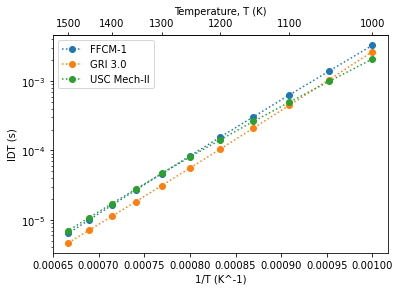

In [11]:
for mech in idts:
    plt.semilogy(1/Ts_idt, idts[mech], ':o', label=str(mech))
plt.legend()
plt.xlabel('1/T (K^-1)')
plt.ylabel('IDT (s)')

'''move the following three lines of code after your code to create the Arrhenius plot to add a secondary
 temperature axis to the top of your plot (to make reading it easier)'''
secx = plt.gca().secondary_xaxis('top', functions=(lambda x: 1 / x, lambda x: 1 / x))
secx.set_xticks([1500, 1400, 1300, 1200, 1100, 1000])
secx.set_xlabel('Temperature, T (K)');

__2 b) Calculate and print the effective Arrhenius activation energy $E_\mathrm{A,eff}$ for the IDT of each mechanism.__

__Comment on the values you find, particularly with respect to how they might compare between mechanisms and how they
 relate to activation energies you have seen for elementary reactions so far in this course.__

In deriving an appropriate expression for calculating $E_\mathrm{A,eff}$, assume $\tau_\mathrm{ign}$ might be reasonably
 expressed as:

$$\tau_\mathrm{ign} = A\exp\left(\frac{E_\mathrm{A,eff}}{RT}\right)$$

_Hint:_ You might find the numpy `polyfit` function helpful

__SOLUTION:__

$$\tau_\mathrm{ign} = A\exp\left(\frac{E_\mathrm{A,eff}}{RT}\right)$$

$$\tau_\mathrm{ign} = \exp(\ln(A))\exp\left(\frac{E_\mathrm{A,eff}}{RT}\right) = \exp\left(\frac{E_\mathrm{A,eff}}{RT} + \ln(A)\right)$$

$$\ln(\tau_\mathrm{ign}) = \frac{E_\mathrm{A,eff}}{RT} + \ln(A) = mx + b$$

$$x = 1/T;\ \ m = \frac{E_\mathrm{A,eff}}{R};\ \ b = \ln(A)$$

$$E_\mathrm{A,eff} = m * R$$

In [12]:
R = 1.987e-3  # kcal/mol-K

'''Type your code to calculate and print the activation energies here'''
for mech in idts:
    y = np.log(idts[mech])
    x = np.array(1/Ts_idt)
    mb = np.polyfit(x, y, 1)
    Ea = mb[0] * R
    print(f'{mech+":":12s} {Ea:3.1f} kcal/mol')

FFCM-1:      37.3 kcal/mol
GRI 3.0:     37.8 kcal/mol
USC Mech-II: 34.1 kcal/mol


_Type response to 2b. here (i.e. comments on activation energies):_

E.g.
* Activation energies in reasonable agreement (especially FFCM-1 and GRI)
* Activation energy for USC Mech-II lower than for other two
* Activation energy falls in range expected of molecule-molecule reactions (20-50 kcal/mol per top of pg. 16)

# 3. Sensitivity Analysis

In this question, we will start to try to make sense of the similarities and differences between the reaction
 mechanisms using sensitivity analysis.

__3 a) Run brute-force IDT sensitivity analysis on the first two mechanisms only. Plot the sensitivities for the 10
 most sensitive reactions.__

__Note:__ The sensitivity analysis for the first two mechanisms should take ~1 minute each to run.
For USC Mech-II, the full sensitivity analysis takes about 20 minutes, which is a long time to sit and wait, so you
 are instead given a pre-computed plot of its results, which is loaded and displayed using provided code.

_Hint:_ You will find the `calculate_sensitivities` function helpful for this part.

Calculating sensitivities for FFCM-1:
	Calculation time =  40 seconds for 291 reactions
Calculating sensitivities for GRI 3.0:
	Calculation time =  55 seconds for 325 reactions


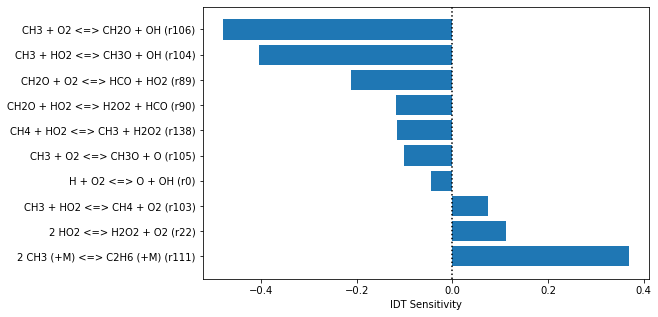

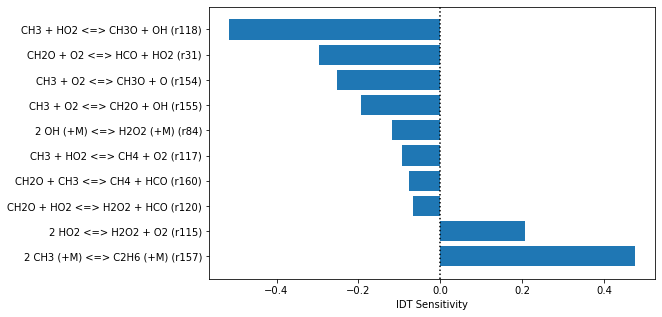

In [13]:
'''Type your code in this cell (and additional cells as needed) to calculate and plot sensitivities
 for the first two reaction mechanisms'''

import time

T = 1200
t_stop = 1e-3

sensitivities = {}
for mech, gas in zip(mech_list[:-1], gas_list[:-1]):
    t1 = time.time()
    print(f'Calculating sensitivities for {mech}:')
    sensitivities[mech] = calculate_sensitivities(gas, T=T, P=P, phi=phi, f=fuel, ox=oxidizer, t_stop=t_stop)
    print(f'\tCalculation time = {time.time()-t1:3.0f} seconds for {gas.n_reactions} reactions')

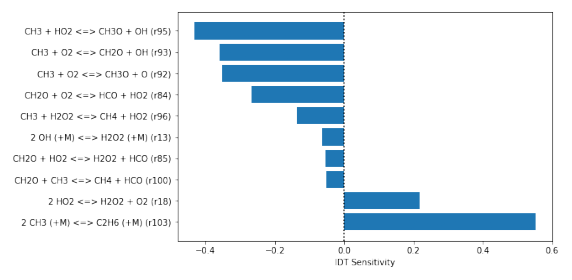

In [14]:
'''Do not change code in this cell; displays pre-calculated USC Mech-II sensitivity results'''

plt.figure(figsize=(10, 8))
plt.imshow(plt.imread(os.path.abspath('../data/USCMechII_sensitivity_1200K_100atm.png')))
plt.axis('off');

__3 b) Comment on the sensitivity results.
 Are there reactions the IDT is highly sensitive to across all the different mechanisms?
 Are there any reactions that the IDT is only sensitive to in one/some mechanisms but not others?
 Based on these results, do you think there are any important reaction pathways included in one/some mechanisms
  but not others?__

_Type response to 3b. here_

E.g.
* The most sensitive reactions are all common across mechanisms
* The "most important reaction" [H + O2 -> OH + H] only appears in the top-10 sensitive reactions for FFCM-1
* The results suggest all the mechanisms share a dominant reaction pathway

__3 c) Now consider the most-sensitive reaction in each the positive and negative directions
 (they should be the same two reactions for all 3 mechanisms).__
* How would each of these reactions be classified (e.g. initiation, propagation, chain branching, termination)?
* What species is in common between these reactions?
* Why do you think these reactions might be the most positively and negatively sensitive?

_Type response to 3c. here_

E.g.
* The most negatively sensitive, [CH3 + O2 <-> CH2O + OH] is a propagation reaction
  * CH3 and OH are radicals
  * O2 and CH2O are stable (though CH2O is likely more reactive)
* The most positively sensitive, [2CH3 (+M) <-> C2H6 (+M)] is a termination reaction
  * Two CH3 radicals combine into a single, stable C2H6 molecule
* Reactions define competing reaction pathways for CH3
  * First reaction converts CH3 to other radicals, allowing further propagation/branching to take place
  * Second reaction removes reactive radicals from the radical pool, inhibiting ignition (and promoting soot)


__3 d) Now, run brute-force IDT sensitivity analysis on the FFCM-1 mechanisms at the following conditions:__
* T = 1800 K
* phi = 1
* oxidizer = 21% O2, 79% N2
* pressures of 100 atm and 0.1 atm

__After generating your plots, comment on the difference in the sensitivity results between the two pressures.
 Why might IDT be more sensitive to some classes of reaction at high pressure than at low pressure?__

Calculating sensitivities for 100.0 atm:
Calculating sensitivities for 0.1 atm:


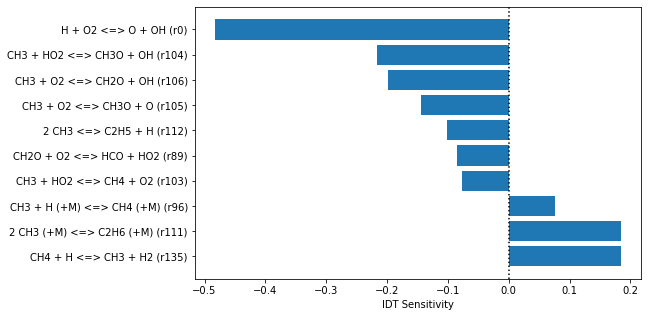

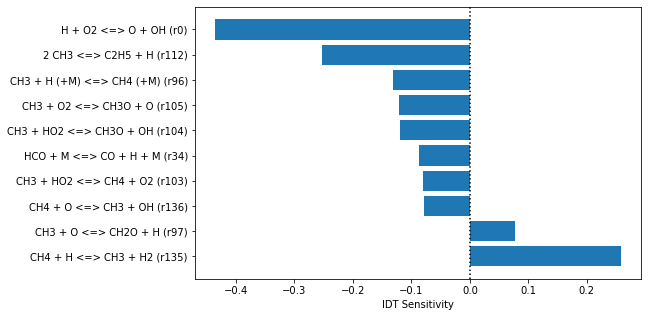

In [15]:
'''Type your code to calculate and plot sensitivities for pressures of 100 atm and 0.1 atm'''

T = 1800.  # K
Ps_sens = np.array([100, 0.1])  # atm
oxidizer = {'O2':.21, 'N2':.79}

sensitivities_P = {}
gas = gas_list[0]

for P in Ps_sens:
    print(f'Calculating sensitivities for {P} atm:')
    sensitivities_P[P] = calculate_sensitivities(gas, T=T, P=P*101325, phi=phi, f=fuel, ox=oxidizer, t_stop=1e-1)

_Type comments for 3d. here regarding the sensistivies at different pressures_

E.g.
* Three-body termination reactions that inhibit ignition at high pressure become very unlikely at low pressure do to
 reduced collision frequencies
  * No 2CH3 + M <-> C2H6 + M sensitivity at low P
* Equilibrium shifts non-mole-conserving reactions (e.g. CH4 + M <-> CH3 + H + M) to favor the initiation direction
 over the terminating direction
  * CH3 + H + M <-(>) CH4 + M has negative sensitivity (promotes ignition) at 0.1 atm
  * CH3 + H + M (<)-> CH4 + M has positive sensitivity (inhibits ignition) at 100 atm

__3 e) Concept Check: How does increasing the (forward) rate multiplier of a reversible reaction affect the reverse
 reaction rate? Why?__

_Type your answer for 3e. here_


# 4) Species-Time Histories

While IDT provides an important global performance target by which mechanisms can be evaluated, measurements of how
 individual species concentrations evolve through time can provide significant insight into the internal workings of a
 reactive system.
In this question, you are asked to compare the concentrations of chemical species during an ignition process.
You are subsequently asked to select which species you think a measurement of would most contribute to identifying
 which mechanism is the most correct at this condition.

__4 a) Simulate the ignition of a rich mixture of propane and air using each of the 3 mechanisms at the
 following conditions:__
* T = 1400 K
* P = 10 atm
* phi = 2

__Save your complete simulation results (not just the IDTs), as they will be used in later parts.__

_Hint:_ Remember the `run_simulation` function

In [16]:
'''type your code to run the ignition simulations in this cell and additional cells as needed'''

results = {}
for mech, gas in zip(mech_list, gas_list):
    results[mech] = run_simulation(gas, T=1400, P=101325*10, phi=2., f={'CH4':1}, ox={'O2':.21,'N2':.79}, t_stop=1e-1)
    # plot_simulation_result(results[mech])

__4 b) Imagine the following lists of species are measurable with laser diagnostics to the specified detection limits:__

Stable species (100 ppm detection limit):
* CH4
* H2O
* CO2
* C2H6
* C2H4
* C2H2

Radical species (1 ppm detection limit):
* OH
* CH
* CH3
* HO2

__For each species, make a plot comparing the mole fraction vs. time as predicted by each of the mechanisms.__

_Notes:_
* Make sure plots are appropriately labeled, at minimum, with the name of the species being plotted and a legend
 matching lines to mechanisms.
* Plot mole fractions on a loglog scale
  * The minimum of the mole-fraction axis should be the detection limit
  * The minimum of the time axis should correspond to a maximum measurement rate of 100 kHz (i.e. 1e-5 seconds)

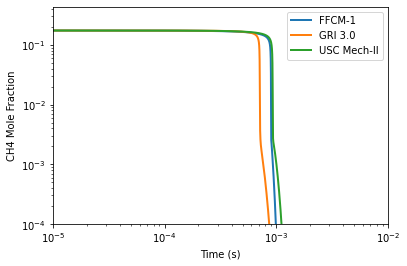

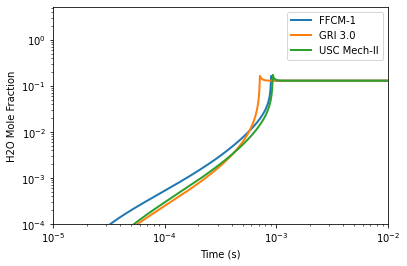

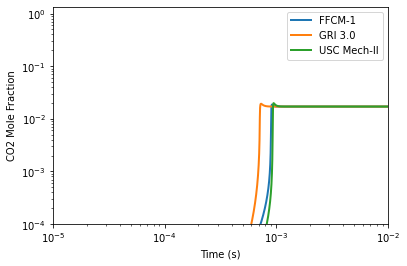

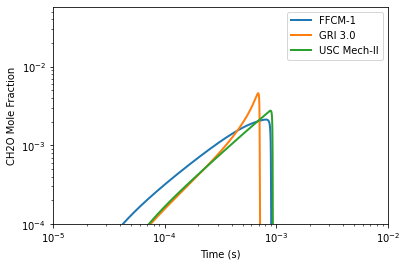

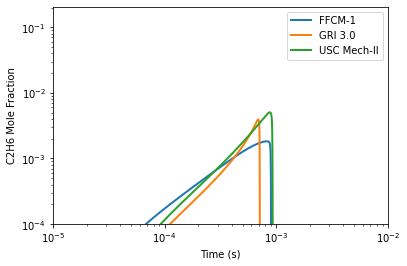

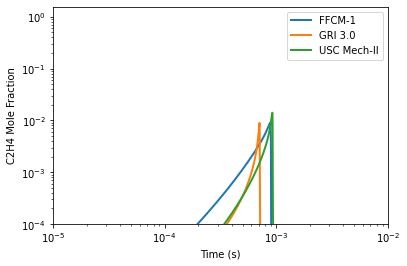

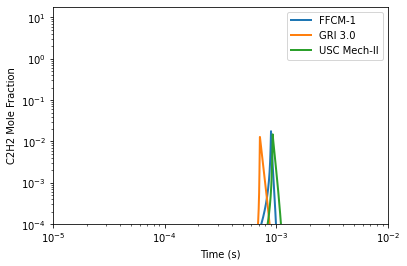

In [17]:
measurable_stables = ['CH4', 'H2O', 'CO2', 'CH2O', 'C2H6', 'C2H4', 'C2H2']
measurable_radicals = ['OH', 'CH', 'CH3', 'HO2']

'''Type code for plotting species comparisons here'''

for sp in measurable_stables:
    plt.figure()
    for mech in results:
        plt.loglog(results[mech]['time'], results[mech][sp], label=str(mech), lw=2)
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel(f'{sp} Mole Fraction')
    plt.ylim((100e-6, plt.gca().get_ylim()[1]))
    plt.xlim((1e-5, 1e-2))
    # plt.axhline(1e-4, ls=':', c='k')

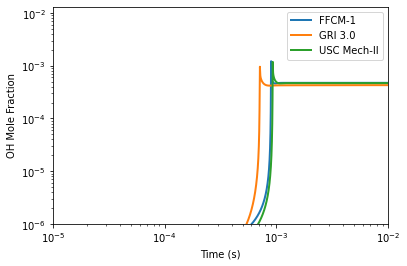

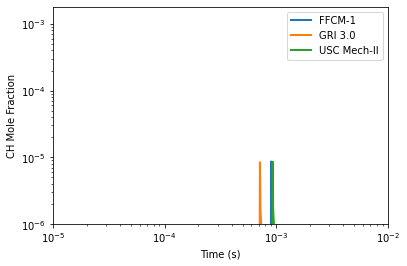

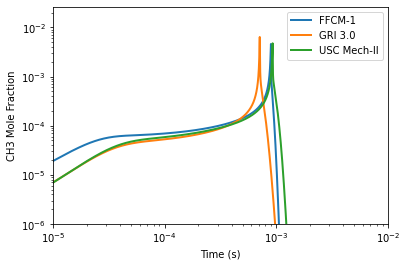

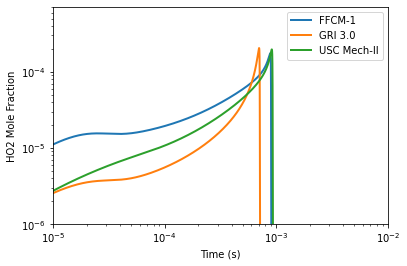

In [18]:
for sp in measurable_radicals:
    plt.figure()
    for mech in results:
        plt.loglog(results[mech]['time'], results[mech][sp], label=str(mech), lw=2)
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel(f'{sp} Mole Fraction')
    plt.ylim((1e-6, plt.gca().get_ylim()[1]))
    plt.xlim((1e-5, 1e-2))
    # plt.axhline(1e-6, ls=':', c='k')

__4 c) Based on your species-vs-time plots, which species would you measure if you were tasked with identifying
 which reaction mechanism was "most correct" at these conditions? Why?__

_Type your answer to 4c. here_

E.g.

* HO2: displays significant differences in the value of the mole fraction and/or the shape of the curve between
 mechanisms
* CH2O, C2H6, or C2H4: differences in the peak mole fraction at the time of ignition and the shape of the formation
 curve

# $\mathcal{The\ \ End}$
